# 0. IMPORTAÇÕES DE BIBLIOTECAS E DADOS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import drive

drive.mount('/content/drive')

np.random.seed(18)

Mounted at /content/drive


In [3]:
# Carrega o arquivo CSV para um DataFrame do Pandas

file_path = '/content/drive/MyDrive/MESTRADO/Ciencia de dados/Online_Sales_Data.csv'
df = pd.read_csv(file_path)

print(f"--- ✔️ CSV loaded successfully from: {file_path} ---")
print(df.head())

--- ✔️ CSV loaded successfully from: /content/drive/MyDrive/MESTRADO/Ciencia de dados/Online_Sales_Data.csv ---
   Transaction ID        Date Product Category             Product Name  \
0           10001  2024-01-01      Electronics            iPhone 14 Pro   
1           10002  2024-01-02  Home Appliances         Dyson V11 Vacuum   
2           10003  2024-01-03         Clothing         Levi's 501 Jeans   
3           10004  2024-01-04            Books        The Da Vinci Code   
4           10005  2024-01-05  Beauty Products  Neutrogena Skincare Set   

   Units Sold  Unit Price  Total Revenue         Region Payment Method  
0           2      999.99        1999.98  North America    Credit Card  
1           1      499.99         499.99         Europe         PayPal  
2           3       69.99         209.97           Asia     Debit Card  
3           4       15.99          63.96  North America    Credit Card  
4           1       89.99          89.99         Europe         PayPal  

# 1. AGREGAÇÃO DAS MÉTRICAS E SEGMENTAÇÃO DE PREÇOS

In [4]:
# 1.1.1. Agregação das Métricas
df_metrics = df.groupby(['Product Name', 'Product Category']).agg(
    Total_Revenue=('Total Revenue', 'sum'),
    Total_Units_Sold=('Units Sold', 'sum'),
    Frequency_of_Order=('Transaction ID', 'nunique'),
    Avg_Unit_Price=('Unit Price', 'mean')
).reset_index()

In [5]:
# 1.1.2. Função de Segmentação de Preço
def price_segmentation(row):
    """Classifica o produto como Barato, Médio ou Caro baseado na Média e STD da categoria."""
    mean = row['Category_Price_Mean']
    std = row['Category_Price_Std']
    price = row['Avg_Unit_Price']

    if pd.isna(std) or std == 0:
        return 'Medio'

    if price < (mean - 0.5 * std):
        return 'Barato'
    elif price > (mean + 0.5 * std):
        return 'Caro'
    else:
        return 'Medio'

In [6]:
# Calcula Estatísticas de Preço por Categoria
category_stats = df_metrics.groupby('Product Category')['Avg_Unit_Price'].agg(['mean', 'std']).reset_index()
category_stats.rename(columns={'mean': 'Category_Price_Mean', 'std': 'Category_Price_Std'}, inplace=True)
df_metrics = pd.merge(df_metrics, category_stats, on='Product Category', how='left')

In [7]:
# Aplica a segmentação
df_metrics['Price_Segment'] = df_metrics.apply(price_segmentation, axis=1)

print("Segmentação de Preço Aplicada")

Segmentação de Preço Aplicada


# 2. CÁLCULO DO SCORE DE RECOMENDAÇÃO (MÉTODO DE DESEMPENHO)


In [8]:
# 2.1. Normalização Min-Max
score_columns = ['Total_Revenue', 'Total_Units_Sold', 'Frequency_of_Order']
scaler = MinMaxScaler()
df_metrics[score_columns] = scaler.fit_transform(df_metrics[score_columns])

df_metrics.rename(columns={
    'Total_Revenue': 'Total_Revenue_Norm',
    'Total_Units_Sold': 'Total_Units_Sold_Norm',
    'Frequency_of_Order': 'Frequency_of_Order_Norm'
}, inplace=True)

In [9]:
# 2.2. Cálculo do Score Final Ponderado
W_REVENUE = 0.50
W_QUANTITY = 0.30
W_FREQUENCY = 0.20

df_metrics['Recommendation_Score'] = (
    (df_metrics['Total_Revenue_Norm'] * W_REVENUE) +
    (df_metrics['Total_Units_Sold_Norm'] * W_QUANTITY) +
    (df_metrics['Frequency_of_Order_Norm'] * W_FREQUENCY)
)

df_metrics_final = df_metrics.sort_values(by='Recommendation_Score', ascending=False)

# 3. CÁLCULO DINÂMICO DO K ÓTIMO (MÉTODO DO GANHO MARGINAL)

In [10]:
def find_optimal_k_by_marginal_gain(df_category, min_marginal_gain=0.05):
    """
    Determina o número ideal de produtos (k) onde a contribuição marginal
    do próximo produto para a receita total (normalizada) da categoria
    é menor que o limite (min_marginal_gain).
    """

    # Ordenar pela nova coluna agregada: 'Total_Revenue_Norm'
    df_category = df_category.sort_values(by='Total_Revenue_Norm', ascending=False).reset_index(drop=True)

    # Normalização da Receita Total *dentro da CATEGORIA*
    max_revenue = df_category['Total_Revenue_Norm'].sum()
    if max_revenue == 0:
        return 1

    # Contribuição normalizada de cada produto
    contribution = df_category['Total_Revenue_Norm'] / max_revenue

    k = 0
    for i in range(len(contribution)):
        marginal_gain = contribution.iloc[i]

        if marginal_gain < min_marginal_gain:
            return k

        k += 1

    return len(contribution)


# Define o limite de contribuição (Ganho Marginal Mínimo)
MIN_MARGINAL_GAIN = 0.02

optimal_k_results = {}
# Usamos o df_metrics_final, mas a função ordena e normaliza internamente.
grouped_products = df_metrics_final.groupby('Product Category')

for category, group in grouped_products:
    k_optimal = find_optimal_k_by_marginal_gain(group, min_marginal_gain=MIN_MARGINAL_GAIN)
    optimal_k_results[category] = k_optimal

print(f"--- ❑️ 3. Número Ótimo de Produtos (K) por Categoria (Ganho Marginal Mínimo: {MIN_MARGINAL_GAIN*100}%) ---")
print(pd.Series(optimal_k_results).sort_index().to_markdown())

--- ❑️ 3. Número Ótimo de Produtos (K) por Categoria (Ganho Marginal Mínimo: 2.0%) ---
|                 |   0 |
|:----------------|----:|
| Beauty Products |  18 |
| Books           |  18 |
| Clothing        |  22 |
| Electronics     |  19 |
| Home Appliances |  22 |
| Sports          |  19 |


## 3.5. VISUALIZAÇÃO DO INSIGHT DO K ÓTIMO (PARETO/GANHO MARGINAL)


--- 📉 3.5. Visualização do Ganho Marginal (Validação do K Ótimo) ---


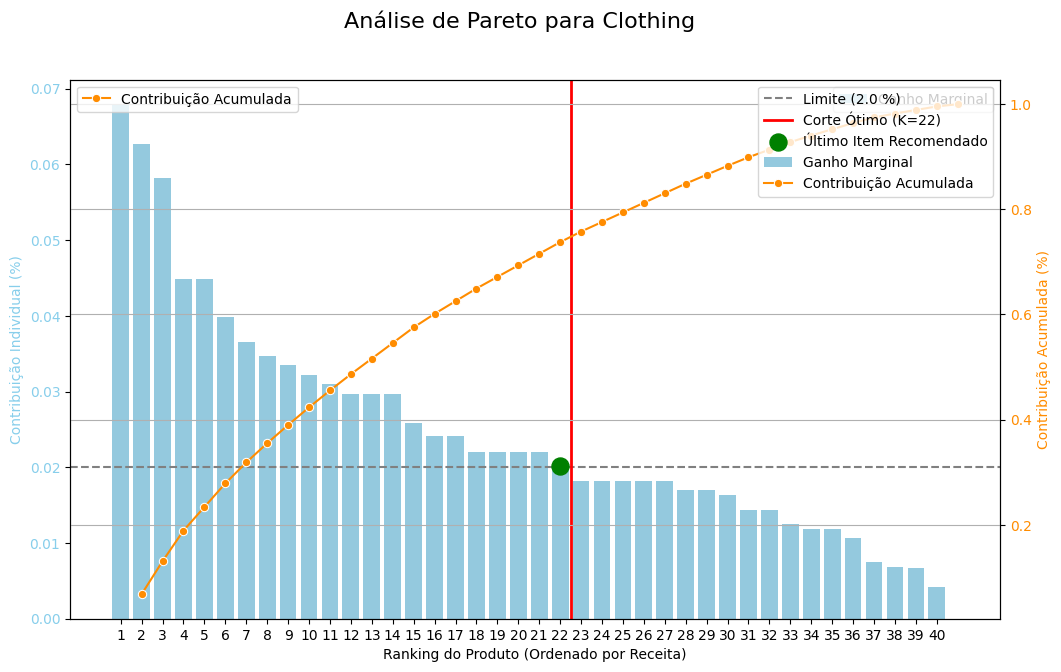

In [11]:
print("\n--- 📉 3.5. Visualização do Ganho Marginal (Validação do K Ótimo) ---")

# Escolha uma categoria para plotar
CATEGORY_TO_PLOT = 'Clothing'
k_optimal = optimal_k_results.get(CATEGORY_TO_PLOT)

# 1. Preparação dos dados para o plot
df_plot = df_metrics_final[df_metrics_final['Product Category'] == CATEGORY_TO_PLOT].copy()
df_plot = df_plot.sort_values(by='Total_Revenue_Norm', ascending=False).reset_index(drop=True)

# Normaliza e calcula o acumulado
total_category_revenue = df_plot['Total_Revenue_Norm'].sum()
df_plot['Contribution'] = df_plot['Total_Revenue_Norm'] / total_category_revenue
df_plot['Cumulative_Contribution'] = df_plot['Contribution'].cumsum()
df_plot['Product_Rank'] = df_plot.index + 1

# 2. Criação do gráfico (Duplo Eixo Y: Contribuição Individual vs. Acumulada)
fig, ax1 = plt.subplots(figsize=(12, 7))

# Gráfico de Barras: Contribuição Individual (Ganho Marginal)
sns.barplot(x='Product_Rank', y='Contribution', data=df_plot, color='skyblue', ax=ax1, label='Ganho Marginal')
ax1.set_xlabel('Ranking do Produto (Ordenado por Receita)')
ax1.set_ylabel('Contribuição Individual (%)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Linha Horizontal: Limite de Ganho Marginal
ax1.axhline(y=MIN_MARGINAL_GAIN, color='gray', linestyle='--', label=f'Limite ({MIN_MARGINAL_GAIN*100} %)')

# Marcador de Corte
if k_optimal > 0 and k_optimal <= len(df_plot):
    ax1.axvline(x=k_optimal - 0.5, color='red', linestyle='-', label=f'Corte Ótimo (K={k_optimal})', linewidth=2)
    plt.scatter(k_optimal - 1, df_plot.iloc[k_optimal - 1]['Contribution'], color='green', s=150, zorder=5, label='Último Item Recomendado')


# 3. Segundo Eixo Y: Curva de Pareto (Acumulado)
ax2 = ax1.twinx()
sns.lineplot(x='Product_Rank', y='Cumulative_Contribution', data=df_plot, color='darkorange', marker='o', ax=ax2, label='Contribuição Acumulada')
ax2.set_ylabel('Contribuição Acumulada (%)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Título e Legendas
fig.suptitle(f'Análise de Pareto para {CATEGORY_TO_PLOT}', fontsize=16)
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()

# 4. GERAÇÃO DA TABELA DE INSIGHTS/RECOMENDAÇÃO COM K VARIÁVEL

In [12]:
recommendations_list = []

for category, k_optimal in optimal_k_results.items():
    df_category = df_metrics_final[df_metrics_final['Product Category'] == category]

    if k_optimal == 0:
        continue

    top_k_products = df_category.head(k_optimal)

    # Lógica para garantir variedade de preço (pega o melhor de cada segmento nos top K)
    temp_recommendations = []

    for segment in top_k_products['Price_Segment'].unique():
        # Pega o melhor item de cada segmento presente nos top K
        best_in_segment = top_k_products[top_k_products['Price_Segment'] == segment].head(1)
        temp_recommendations.append(best_in_segment)

    recommended_so_far = pd.concat(temp_recommendations)
    remaining_k = k_optimal - len(recommended_so_far)

    if remaining_k > 0:
        remaining_products = top_k_products[~top_k_products.index.isin(recommended_so_far.index)].head(remaining_k)
        final_k_group = pd.concat([recommended_so_far, remaining_products])
    else:
        final_k_group = recommended_so_far

    final_k_group['Recommendation_Type'] = f'{category} (K={k_optimal} Ótimo)'
    recommendations_list.append(final_k_group)

df_recommendations = pd.concat(recommendations_list)

final_recommendation_table = df_recommendations[[
    'Recommendation_Type',
    'Product Name',
    'Price_Segment',
    'Avg_Unit_Price',
    'Total_Revenue_Norm',
    'Recommendation_Score'
]].sort_values(by=['Recommendation_Type', 'Recommendation_Score'], ascending=[True, False])

In [13]:
print("\n--- Insight Principal: Produtos de Melhor Desempenho por Nicho ---")
print(final_recommendation_table.to_markdown(index=False, floatfmt=".2f"))


--- Insight Principal: Produtos de Melhor Desempenho por Nicho ---
| Recommendation_Type          | Product Name                                       | Price_Segment   |   Avg_Unit_Price |   Total_Revenue_Norm |   Recommendation_Score |
|:-----------------------------|:---------------------------------------------------|:----------------|-----------------:|---------------------:|-----------------------:|
| Beauty Products (K=18 Ótimo) | Dyson Supersonic Hair Dryer                        | Caro            |           399.99 |                 0.10 |                   0.05 |
| Beauty Products (K=18 Ótimo) | L'Oreal Revitalift Serum                           | Medio           |            39.99 |                 0.02 |                   0.04 |
| Beauty Products (K=18 Ótimo) | First Aid Beauty Ultra Repair Cream                | Medio           |            34.00 |                 0.02 |                   0.04 |
| Beauty Products (K=18 Ótimo) | L'Occitane Shea Butter Hand Cream           

#5. EXPORTAÇÃO DOS DADOS

In [19]:
def export_to_excel(df, filename="relatorio_recomendacao_final.xlsx", sheet_name="Recomendacoes"):
        df.to_excel(
            filename,
            sheet_name=sheet_name,
            index=False,
            engine='xlsxwriter'
        )
        print(f"\n✅ Sucesso! Os resultados foram exportados para: '{filename}' na aba '{sheet_name}'.")

# EXECUTAR A EXPORTAÇÃO
export_to_excel(final_recommendation_table)


✅ Sucesso! Os resultados foram exportados para: 'relatorio_recomendacao_final.xlsx' na aba 'Recomendacoes'.
